In [317]:
import numpy as np                     # numeric python lib
import pandas as pd
import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour
import os
from skimage import io            # to find shape contour
import scipy.ndimage as ndi 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)
import warnings
warnings.filterwarnings(
    module='imshow',
    action='ignore',
    message=('Clipping')
    )

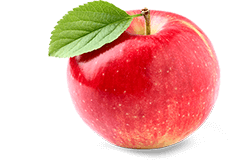

In [318]:
image = Image.open('trainfruit/apple_8.jpg')

image

In [319]:
img = np.array(Image.open('trainfruit/apple_8.jpg'))
img.flatten().sum()

2213596

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/PIL/Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


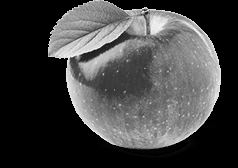

In [320]:
image = Image.open('trainfruit/apple_8.jpg').convert('L')
image

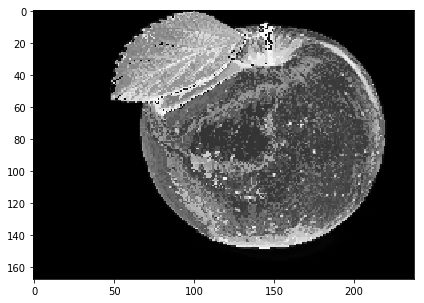

In [321]:
io.imshow(img)

In [322]:
im = np.array(img)
len(im.flatten('C'))

39984

In [323]:
img2 = ndi.filters.gaussian_filter(img,2)

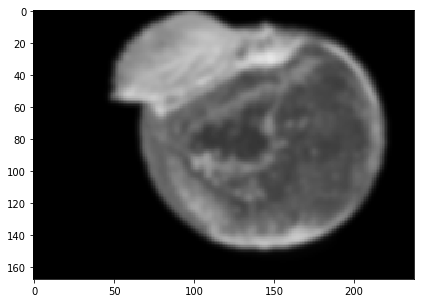

In [324]:
io.imshow(img2)

In [325]:
from PIL import Image
import os

In [326]:
from skimage.transform import resize

In [327]:
from skimage.io import imread_collection
from skimage import color


#creating a collection with the available images
def make_data (path):
    imgs = imread_collection(path)              #read directory of images
    imgs = [resize(x,(100,100))for x in imgs]   #resize images to uniform size
    imgs = [ x[:,:,:3] for x in imgs]           #drop alpha channel if present
    imgs = [x.flatten('C') for x in imgs]       #flatten image to array
    return imgs

In [328]:
dataw = make_data('trainfruit/*.jpg')
dataw[:5]

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([3.47607843e-01, 7.84313725e-05, 3.63137255e-02, ...,
        9.80862745e-01, 6.91058824e-01, 6.71450980e-01]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([0.30352941, 0.26823529, 0.24627451, ..., 0.03921569, 0.03529412,
        0.02745098])]

In [329]:
apples = pd.Series(['Apple' for _ in range(75)])
banns = pd.Series(['Banana' for _ in range(73)])
mixed = pd.Series(['Mixed' for _ in range(20)])
orange = pd.Series(['Orange' for _ in range(72)])

In [330]:
target = pd.concat([apples, banns, mixed, orange])

In [331]:
target.value_counts()

Apple     75
Banana    73
Orange    72
Mixed     20
dtype: int64

In [332]:
X = dataw
y = target

#X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3,shuffle=True, random_state=43)


In [333]:
lrci = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')

In [334]:
rbm = BernoulliRBM(random_state=86, verbose=True)
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', lrci)])
rbm.learning_rate = 0.03
rbm.n_iter = 30
rbm.n_components = 100
lrci.C = 200

rbm_features_classifier.fit(X_train, y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -18112.48, time = 1.76s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -18392.36, time = 1.89s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -18446.67, time = 1.86s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -17332.03, time = 1.83s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -17169.25, time = 1.95s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -17362.10, time = 1.88s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -17969.11, time = 1.85s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -18224.58, time = 1.99s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -17380.30, time = 1.99s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -17748.73, time = 1.94s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -18080.27, time = 2.06s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -18097.29, time = 2.02s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -17617.65, time = 1.95s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -17754.43, 

Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.03, n_components=100, n_iter=30,
       random_state=86, verbose=True)), ('logistic', LogisticRegression(C=200, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [335]:
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

Logistic regression using RBM features:
              precision    recall  f1-score   support

       Apple       0.31      1.00      0.47        22
      Banana       0.00      0.00      0.00        25
       Mixed       0.00      0.00      0.00         4
      Orange       0.00      0.00      0.00        21

   micro avg       0.31      0.31      0.31        72
   macro avg       0.08      0.25      0.12        72
weighted avg       0.09      0.31      0.14        72




/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

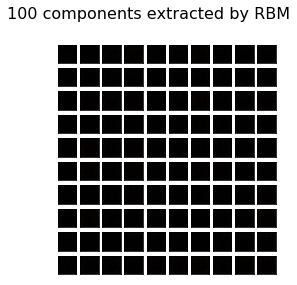

In [336]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((100, 100,3)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.2, 0.05, 0.92, 0.85, 0.2, 0.23)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


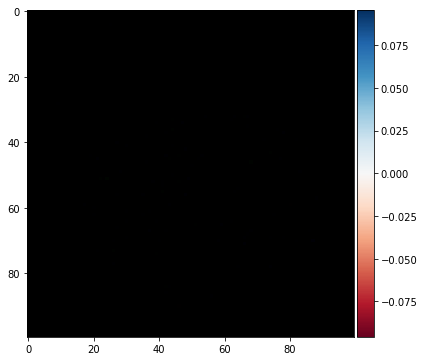

In [316]:
comp1 = rbm.components_[55].reshape(100,100,3)
io.imshow(blah)

In [341]:
rbm = BernoulliRBM(random_state=86, verbose=True)
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', lrci)])
rbm.learning_rate = 0.06
rbm.n_iter = 100
rbm.n_components = 500
lrci.C = 6000

In [342]:
# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(lrci)
raw_pixel_classifier.C = 100
raw_pixel_classifier.fit(X_train, y_train)


[BernoulliRBM] Iteration 1, pseudo-likelihood = -22801.39, time = 12.21s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -20880.99, time = 13.16s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -20553.18, time = 12.29s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -20867.46, time = 12.37s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -20796.98, time = 12.10s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -20185.31, time = 12.17s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20962.91, time = 12.08s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -19935.29, time = 12.21s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20567.78, time = 12.21s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -19870.59, time = 12.32s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20657.59, time = 12.28s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -20146.72, time = 11.49s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -20339.39, time = 10.76s
[BernoulliRBM] Iteration 14, pseudo-likelihood 

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for f

Logistic regression using RBM features:
              precision    recall  f1-score   support

       Apple       0.32      1.00      0.48        22
      Banana       0.67      0.08      0.14        25
       Mixed       0.00      0.00      0.00         4
      Orange       0.00      0.00      0.00        21

   micro avg       0.33      0.33      0.33        72
   macro avg       0.25      0.27      0.16        72
weighted avg       0.33      0.33      0.20        72


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

       Apple       0.91      0.91      0.91        22
      Banana       0.83      0.96      0.89        25
       Mixed       0.33      0.25      0.29         4
      Orange       0.89      0.76      0.82        21

   micro avg       0.85      0.85      0.85        72
   macro avg       0.74      0.72      0.73        72
weighted avg       0.84      0.85      0.84        72




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

ValueError: num must be 1 <= num <= 100, not 101

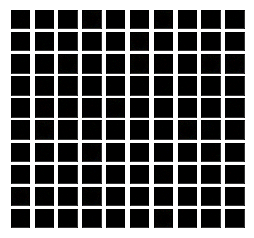

In [343]:
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1 )
    plt.imshow(comp.reshape((100, 100,3)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.2, 0.05, 0.92, 0.85, 0.2, 0.23)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


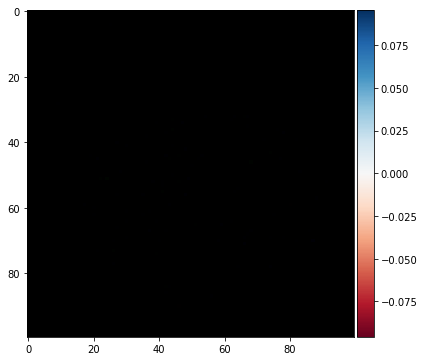

In [344]:
blah = rbm.components_[55].reshape(100,100,3)
io.imshow(blah)

In [345]:
dir(raw_pixel_classifier)

['C',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_estimator_type',
 '_get_param_names',
 '_predict_proba_lr',
 'class_weight',
 'classes_',
 'coef_',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'intercept_scaling',
 'max_iter',
 'multi_class',
 'n_iter_',
 'n_jobs',
 'penalty',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'score',
 'set_params',
 'solver',
 'sparsify',
 'tol',
 'verbose',
 'warm_start']

its hard to visualize the features, however on one iteration that i did not save, I saw some color images for the components, was not able to replicate it. the raw pixel classifier does better. also when increase the compnents and iterations, the model seems to do better, however the computation demands reach beyond a 'tinkering' session.

In [ ]:
raw_pixel_classifier._get